In [1]:
import os
DEVELOPMENT_MODE = False
IN_COLAB = False

# Hot reload in development mode & not running on the CD
if not IN_COLAB:
    from IPython import get_ipython
    ip = get_ipython()
    if not ip.extension_manager.loaded:
        ip.extension_manager.load('autoreload')
        %autoreload 2

IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"
IN_GITHUB = True

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

import circuitsvis as cv
# Testing that the library works
cv.examples.hello("Neel")

# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm.auto as tqdm
import plotly.express as px

from functools import partial

# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix

# LSE.AI specific imports
from munch import Munch
import matplotlib.pyplot as plt
import yaml
import sys
from fancy_einsum import einsum
sys.path.append('./data_and_model/analyse/') 
from samplers import get_data_sampler
from tasks import get_task_sampler
import nbformat
import numpy as np
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1' # for factored matrix
import pandas as pd
from jaxtyping import Float

from hook_model import hook_model, search_heads_get_loss, get_model, get_data, get_acts, PassThroughEmbed 

torch.set_grad_enabled(False)

device = torch.device('cpu')

def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

def validation_metric(predictions, labels, return_one_element, device):
    predictions = predictions.to(device)

    # loss is mse on last 5 predictions (full context)
    loss = (labels.to(device) - predictions.to(device)).square().cpu().numpy().mean(axis=0)[-5:].mean()
    return loss

def get_data(device, conf, read_in_weight, read_in_bias, max_len, return_xs_ys=False):
    # generate random data (20d points on a gaussian)

    n_dims = conf.training.curriculum.dims.end # is: conf.training.curriculum.dims.end should be: conf.model.n_dims
    batch_size = conf.training.batch_size

    data_sampler = get_data_sampler(conf.training.data, n_dims)
    task_sampler = get_task_sampler(
        conf.training.task,
        n_dims,
        batch_size,
        **conf.training.task_kwargs
    )
    task = task_sampler()
    xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end) # should be n_points=conf.training.curriculum.points.end, but has been hacked to work for the max_len of 101 (202)
    ys = task.evaluate(xs)

    # the original model first merges the sequences in z, which we do here (z can have all but the last y since it's causal and intermediate ys are for icl and later icl lenght eval

    batch, n_ctx, d_xs = xs.shape

    ys_wide = torch.cat(
        (
            ys.view(batch, n_ctx, 1),
            torch.zeros(batch, n_ctx, d_xs - 1, device=ys.device),
        ),
        axis=2,
    )
    my_zs = torch.stack((xs, ys_wide), dim=2)
    my_zs = my_zs.view(batch, 2 * n_ctx, d_xs).to(device)

    zeros_to_append = torch.zeros(my_zs.shape[0], my_zs.shape[1], conf.model.n_dims - my_zs.shape[2])

    my_zs = torch.cat((my_zs.to(device), zeros_to_append.to(device)), dim=2)

    # apply the read_in transformation
    transformed_zs = einsum("batch n_ctx d_xs, d_model d_xs -> batch n_ctx d_model", my_zs, read_in_weight) + read_in_bias

    # apply padding

    current_len = transformed_zs.shape[1]
    max_len = 64 # HORRID tech debt I don't get
    pad_len = max(max_len - current_len, 0)

    

    # Apply padding to the right of the second dimension
    # The padding order in F.pad is (left, right, top, bottom) for 4D input, but here it's the equivalent for 3D
    if return_xs_ys:
        return F.pad(transformed_zs, (0, 0, 0, pad_len), "constant", 0).to(device), xs.to(device), ys.to(device)
    return F.pad(transformed_zs, (0, 0, 0, pad_len), "constant", 0), ys.to(device)


class PassThroughEmbed(nn.Module):
        def __init__(self, cfg=None):
            super().__init__()
            # No parameters needed, but constructor accepts cfg for compatibility

        def forward(self, tokens):
            # Directly return the input without any modifications
            return tokens


def plot_loss(pred, labels, conf, device):

    loss = (labels.to(device) - pred.to(device)).square().cpu().numpy()

    baseline = {
        "linear_regression": conf.model.n_dims,
    }[conf.training.task]

    plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
    plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
    plt.xlabel("# in-context examples")
    plt.ylabel("squared error")
    plt.legend()
    plt.show()

def test_model(device, conf, read_in_weight, read_in_bias, max_len, graph=False):
    input, labels = get_data(device, conf, read_in_weight, read_in_bias, max_len)

    with torch.no_grad():
        my_pred = model(input)[:, ::2, 0][:, torch.arange(labels.shape[1])].cpu() # this last transformation before returning is in the original and I assume only selects the predictions for ys
    
    mse = validation_metric(my_pred, labels, True, device)

    if graph:
        plot_loss(my_pred, labels, conf, device)

    return mse


def get_model(path, device="cpu"):
    class PassThroughEmbed(nn.Module):
        def __init__(self, cfg=None):
            super().__init__()
            # No parameters needed, but constructor accepts cfg for compatibility

        def forward(self, tokens):
            # Directly return the input without any modifications
            return tokens

    model = torch.load(path, map_location=device)
    tl_model = model.to(device)
    tl_model.set_use_attn_result(True)
    tl_model.set_use_split_qkv_input(True)
    if "use_hook_mlp_in" in tl_model.cfg.to_dict():
        tl_model.set_use_hook_mlp_in(True)
    return tl_model

Using renderer: colab


/Users/marcomolinari/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
config_path = "config.yaml" # nuvolous path: "data_and_model/analyse/config.yaml"
with open(config_path) as fp:  # we don't Quinfig it to avoid inherits
    conf = Munch.fromDict(yaml.safe_load(fp))
model = get_model('./weights/last_final_toy_model.pt', device) # nuvolous path: 'data_and_model/analyse/toy_model.pt'
read_in_weight = torch.load('./weights/last_final_toy_read_in_weight.pt', map_location=device) # nuvolous path: 'data_and_model/analyse/toy_read_in_weight.pt'
read_in_bias = torch.load('./weights/last_final_toy_read_in_bias.pt', map_location=device) # nuvolous path: 'data_and_model/analyse/toy_read_in_bias.pt'

Moving model to device:  cpu


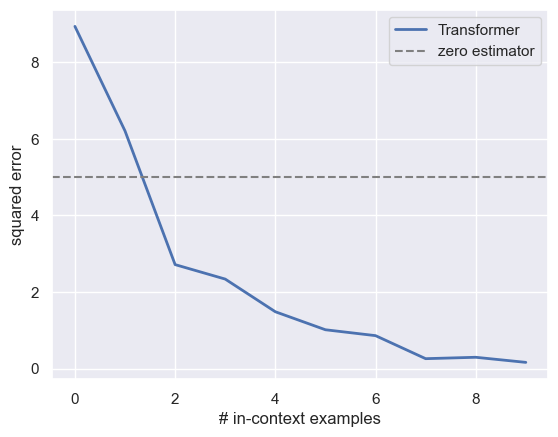

0.5177783

In [3]:
test_model(device, conf, read_in_weight, read_in_bias, model.cfg.n_ctx, True)

# Set up causal experiment

In [4]:
def prep_manual_input(xs, ys):
    batch, n_ctx, d_xs = xs.shape

    ys_wide = torch.cat(
        (
            ys.view(batch, n_ctx, 1),
            torch.zeros(batch, n_ctx, d_xs - 1, device=ys.device),
        ),
        axis=2,
    )
    my_zs = torch.stack((xs, ys_wide), dim=2)
    my_zs = my_zs.view(batch, 2 * n_ctx, d_xs).to(device)

    zeros_to_append = torch.zeros(my_zs.shape[0], my_zs.shape[1], conf.model.n_dims - my_zs.shape[2])

    my_zs = torch.cat((my_zs.to(device), zeros_to_append.to(device)), dim=2)

    # apply the read_in transformation
    transformed_zs = einsum("batch n_ctx d_xs, d_model d_xs -> batch n_ctx d_model", my_zs, read_in_weight) + read_in_bias

    # apply padding

    current_len = transformed_zs.shape[1]
    max_len = 64 # HORRID tech debt I don't get
    pad_len = max(max_len - current_len, 0)

    

    # Apply padding to the right of the second dimension
    # The padding order in F.pad is (left, right, top, bottom) for 4D input, but here it's the equivalent for 3D
    return F.pad(transformed_zs, (0, 0, 0, pad_len), "constant", 0)


In [5]:
# baseline stuff, don't change
xs = torch.tensor([[[1, 1, 1] for i in range(10)]])
ys = torch.tensor([[1 for i in range(10)]])

manual_baseline_input = prep_manual_input(xs, ys)

baseline_output, baseline_cache = model.run_with_cache(manual_baseline_input)
baseline_output = baseline_output[:, ::2, 0][:, torch.arange(ys.shape[1])].cpu()
validation_metric(baseline_output, ys, False, 'cpu')

0.046146598

In [6]:
corrupt_xs = torch.tensor([[[2, 2, 2] for i in range(10)]])
corrupt_ys = torch.tensor([[2 for i in range(10)]])

manual_corrupt_input = prep_manual_input(corrupt_xs, corrupt_ys)

corrupt_output, corrupt_cache = model.run_with_cache(manual_corrupt_input)
corrupt_output = corrupt_output[:, ::2, 0][:, torch.arange(ys.shape[1])].cpu()
validation_metric(corrupt_output, corrupt_ys, False, 'cpu')

0.4286701

In [7]:
xs.shape, ys.shape, manual_baseline_input.shape, corrupt_xs.shape, corrupt_ys.shape, manual_corrupt_input.shape

(torch.Size([1, 10, 3]),
 torch.Size([1, 10]),
 torch.Size([1, 64, 64]),
 torch.Size([1, 10, 3]),
 torch.Size([1, 10]),
 torch.Size([1, 64, 64]))

In [8]:
layer = 0
head = 0

In [9]:
def get_hooked_preds(input, labels, old_cache, nex_cache):
    '''
    Mind this function only replaces the embedding!!
    we are patching in new xs in A00
    likely we are gonna need to adjust for subsequent components
    '''

    model.reset_hooks()

    def xs_attn0_patching_hook(
        resid_pre: Float[torch.Tensor, "batch pos d_model"],
        hook: HookPoint,
    ) -> Float[torch.Tensor, "batch pos d_model"]:
        # Each HookPoint has a name attribute giving the name of the hook.
        
        corrupt_embedding = nex_cache[f'blocks.{str(layer)}.hook_resid_pre']
        clean_embedding = old_cache[f'blocks.{str(layer)}.hook_resid_pre']

        # ::2 for xs
        resid_pre[:, ::2, head, :] = resid_pre[:, ::2, head, :] - clean_embedding[:, ::2, :] + corrupt_embedding[:, ::2, :]
        return resid_pre

    head_0_xs_patched_preds = model.run_with_hooks(input, fwd_hooks=[
        (utils.get_act_name('blocks.0.hook_v_input'), xs_attn0_patching_hook)
    ])[:, ::2, 0][:, torch.arange(labels.shape[1])].cpu()
    head_0_xs_ablated_loss = validation_metric(head_0_xs_patched_preds, labels, False, 'cpu')

    model.reset_hooks()
    return head_0_xs_patched_preds

In [10]:
get_hooked_preds(manual_baseline_input, ys, baseline_cache, corrupt_cache)

tensor([[0.0459, 0.5640, 0.3017, 0.0985, 0.0548, 0.0792, 0.1343, 0.2283, 0.3135,
         0.3481]])

In [17]:
file_path = 'a_0_0_patch_dataset.txt'

# Open the file in append mode
with open(file_path, 'a') as file:
    while True:
        # input
        data_sampler = get_data_sampler(conf.training.data, 3)

        patch_in_xs = data_sampler.sample_xs(b_size=1, n_points=conf.training.curriculum.points.end)
        x1, x2, x3 = patch_in_xs[0][0][0], patch_in_xs[0][0][1], patch_in_xs[0][0][2]
        patch_in_xs = torch.tensor([[[x1, x2, x3] for i in range(10)]])

        patch_in_ys = torch.tensor([[1 for i in range(10)]])


        manual_patch_in_input = prep_manual_input(patch_in_xs, patch_in_ys)

        
        # output
        _, patch_in_cache = model.run_with_cache(manual_patch_in_input)
        output_string = str(get_hooked_preds(manual_baseline_input, ys, baseline_cache, patch_in_cache)[0].mean().item())
        output_string = str(x1.item()) + ' ' + str(x2.item()) + ' ' + str(x3.item()) + ' ' + output_string

        # Write the output to the file
        file.write(output_string)
        file.write('\n')  # Optionally add a newline for readability

        # Flush the write buffer to ensure all data is written to the disk
        file.flush()

        # Check the size of the file
        if os.path.getsize(file_path) >= 1 * 1024 * 1024:  # 100kb
            break  # Exit the loop if the file is 100kb or larger